<a href="https://colab.research.google.com/github/toshi47/NER/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')
# Single fully-connected neural layer as encoder and decoder
df = pd.read_csv('/content/drive//My Drive/NER/my_small.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print("Size of the dataframe: ", df.shape);
scaler = MinMaxScaler()
df_values = df.drop(columns=['word', 'tag'], axis=1)
df_norm = scaler.fit_transform(df_values)
original_dim= df.shape[1]-2
print(original_dim)
input_shape = (original_dim, )
print(input_shape)
intermediate_dim = int(original_dim/2)
batch_size = 50
latent_dim = 25
epochs = 150
epsilon_std = 1.0

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()







Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Size of the dataframe:  (183228, 115)
113
(113,)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 113)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 56)           6384        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 25)           1425        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense

Epoch 1/150
2456/2456 - 20s - loss: 16.0192 - val_loss: 12.3525 - 20s/epoch - 8ms/step
Epoch 2/150
2456/2456 - 19s - loss: 11.4389 - val_loss: 10.8423 - 19s/epoch - 8ms/step
Epoch 3/150
2456/2456 - 17s - loss: 10.5131 - val_loss: 10.3318 - 17s/epoch - 7ms/step
Epoch 4/150
2456/2456 - 8s - loss: 10.1013 - val_loss: 9.9538 - 8s/epoch - 3ms/step
Epoch 5/150
2456/2456 - 8s - loss: 9.8568 - val_loss: 9.7926 - 8s/epoch - 3ms/step
Epoch 6/150
2456/2456 - 8s - loss: 9.7204 - val_loss: 9.6639 - 8s/epoch - 3ms/step
Epoch 7/150
2456/2456 - 8s - loss: 9.6098 - val_loss: 9.5819 - 8s/epoch - 3ms/step
Epoch 8/150
2456/2456 - 8s - loss: 9.5362 - val_loss: 9.5293 - 8s/epoch - 3ms/step
Epoch 9/150
2456/2456 - 8s - loss: 9.4923 - val_loss: 9.4878 - 8s/epoch - 3ms/step
Epoch 10/150
2456/2456 - 7s - loss: 9.4365 - val_loss: 9.4832 - 7s/epoch - 3ms/step
Epoch 11/150
2456/2456 - 8s - loss: 9.3957 - val_loss: 9.3845 - 8s/epoch - 3ms/step
Epoch 12/150
2456/2456 - 8s - loss: 9.3552 - val_loss: 9.3772 - 8s/epoch

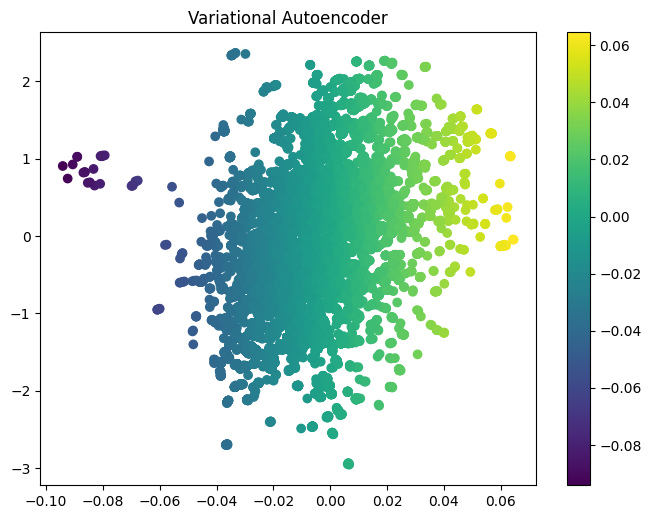

In [2]:
X_train, X_test, y_train, y_test = train_test_split(df_norm, df_norm,
                                                    test_size=0.33, random_state=42)

hist=vae.fit(X_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(X_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
print(X_test.shape)
print(X_test[0])
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
print(x_test_encoded.shape)
print(x_test_encoded)
print(y_test.shape)
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=x_test_encoded[:, 0])
plt.title('Variational Autoencoder')
plt.colorbar()
plt.show()

In [3]:
def plt_hist(hist):
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

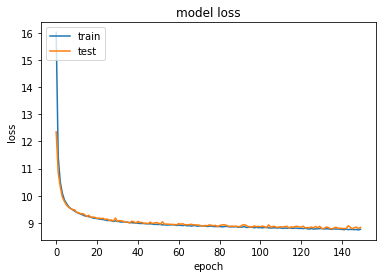

In [4]:
plt_hist(hist)

In [5]:
x_test_encoded = encoder.predict(df_norm, batch_size=batch_size)

['O' 'B-PER' 'I-PER' 'B-LOC' 'B-ORG' 'I-ORG' 'I-LOC']
[6 2 5 0 1 4 3]
Projecting 25-dimensional data to 2D


Text(0.5, 1.0, 'NER. PCA projection')

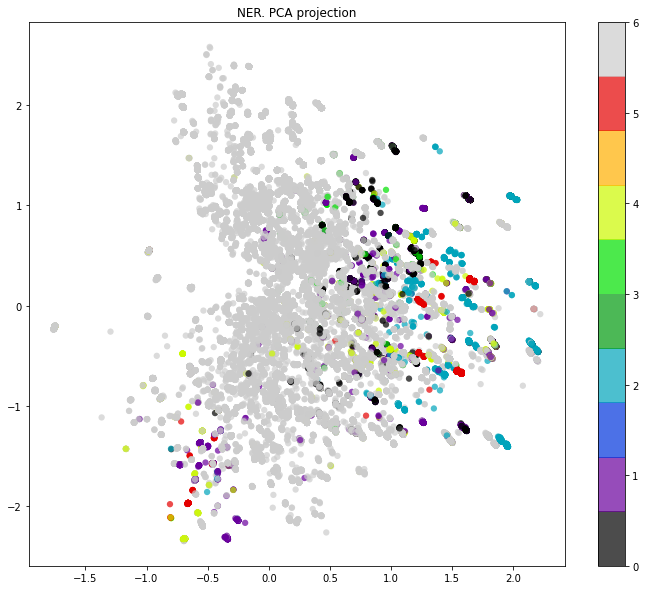

In [6]:
from sklearn.decomposition import PCA
tags=df['tag'].unique()
le = LabelEncoder()
le.fit(tags)
encoded_tags=le.transform(tags)
print(tags)
print(encoded_tags)
pca      = PCA(n_components=2)
x_reduce = pca.fit_transform(x_test_encoded)
print('Projecting %d-dimensional data to 2D' % x_test_encoded.shape[1])
y=le.transform(df['tag'])
plt.figure(figsize=(12,10))
plt.scatter(x_reduce[:, 0], x_reduce[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('NER. PCA projection')